# Setting up the matrix
---

In [23]:
from walker import *
from grid import *
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.sparse as sp
import scipy.sparse.linalg as lg
from numba import jit
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from dask import delayed, compute
import matplotlib.path as mplpath
import time
import os
import sys
import seaborn as sns
import palettable as pl
sns.set()

## Some timings
---

In [3]:
# max_idx_dict = {}
# timing = {}
# s = time.time()
# for g in range(1,6):
#     for p in range(10):
#         print(g, p, "elapsed time:\t", time.time()-s)
#         start = time.time()
#         pdict = koch_walker(depth=g, points_between=p)
#         end = time.time()- start
#         save_grid(pdict, g, p)
#         timing[tuple((g,p))] = end
#         pl = np.array(list(pdict))
#         midx = normalize(pl)
#         max_idx_dict[tuple((g,p))] = midx

In [5]:
# np.save("max_idx_dict", max_idx_dictidx_dict)
# np.save("timings_dict", timing)

In [ ]:
# for k,v in max_idx_dict.items():    
#     diag = np.ones(v**2)
#     diag0 = -4*diag
#     diagx = diag[:-1]
#     diagy = diag[:-v]
#     M = scipy.sparse.diags([diagy, diagx, diag0, diagx, diagy], [-v, -1, 0,1,v], format="csr")
#     st = time.time()
#     e, v = scipy.sparse.linalg.eigs(M)
#     en = time.time()-st
#     np.save(f"solution_time_g_p={k}",[en])

In [7]:
a = np.load("solution_time_g_p=(3, 5).npy")
a
# array([885.44158578]) ~15min

array([885.44158578])

In [28]:
sol_time ={}
for g in range(1, 4):
    for p in range(10):
        k = (g, p)
        path = f"solution_time_g_p={k}.npy"
        if os.path.exists(path):
            t = np.load(path).item()
            sol_time[k] = t

In [20]:
midx_d = np.load("max_idx_dict.npy", allow_pickle=True).item()

---

In [299]:
g = 3 # recursion depth
pts = 1 # points between each corner of the fractal
%time position_dict = koch_walker(depth=g, points_between=pts)
save_grid(position_dict, g, pts)
pos_list = np.array(list(position_dict))
max_idx = normalize(pos_list)
%time normalized_dict = {tuple(p):True for p in pos_list}
max_idx

Wall time: 606 ms
Wall time: 6.98 ms


212

In [149]:
# plt.style.available

(3, 1)

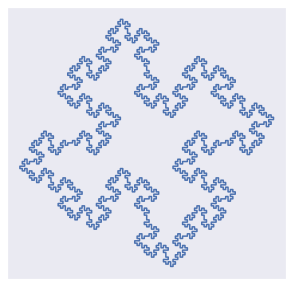

In [300]:
#cmap = pl.scientific.diverging.Berlin_10.colors
#plt.style.use('seaborn-dark-palette')
plt.figure(figsize=(5,5), frameon=False)
plot_list = [*pos_list, pos_list[0]]
plt.plot(*zip(*plot_list))
plt.xticks([])
plt.yticks([])
g, pts

In [301]:
path =mplpath.Path(pos_list)

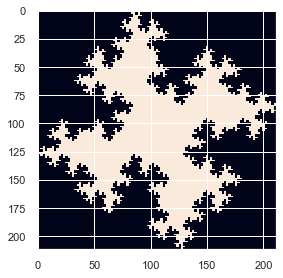

In [302]:
all_points = [(i,j) for i in range(max_idx) for j in range(max_idx)]
f = np.zeros((max_idx, max_idx))
c = np.array([path.contains_point(p) for p in all_points]).reshape((max_idx, max_idx))
f[c] += 1
plt.imshow(f)
plt.plot(*zip(*plot_list))

In [303]:
h = 1/max_idx
k = max_idx
n = (k)**2 # number of unknowns
shape =(k, k)

In [304]:
diag = np.ones(n) / (h**2)
diag0 = 4*diag
diagx = -diag[:-1]
diagy = -diag[:-(max_idx)]

In [305]:
A = scipy.sparse.diags([diagy, diagx, diag0, diagx, diagy], [-max_idx, -1, 0,1,max_idx], format="lil")

In [306]:
%%time
for p in all_points:
    i,j = p
    if normalized_dict.get(p, False) or not path.contains_point(p):
        k = i*max_idx + j
        A[:,k] = 0
        A[k,:] = 0
        

Wall time: 3min 23s


In [336]:
l = scipy.sparse.linalg.spsolve(A, e[0]*v[:,0])

In [310]:
A.shape

(44944, 44944)

In [311]:
c.shape

(212, 212)

In [312]:
shape

(212, 212)

In [342]:
cm = pl.scientific.diverging.Broc_11.get_mpl_colormap()

In [314]:
%time e, v = scipy.sparse.linalg.eigs(A)

Wall time: 38.8 s


In [319]:
tmp = [v[:,i].reshape(shape) / e[0] for i in range(6)]
for t in tmp:
    t[np.flip(c)] *=0.

C:\Users\KarlKristian\Anaconda3\envs\numfys\lib\site-packages\numpy\ma\core.py:2786: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


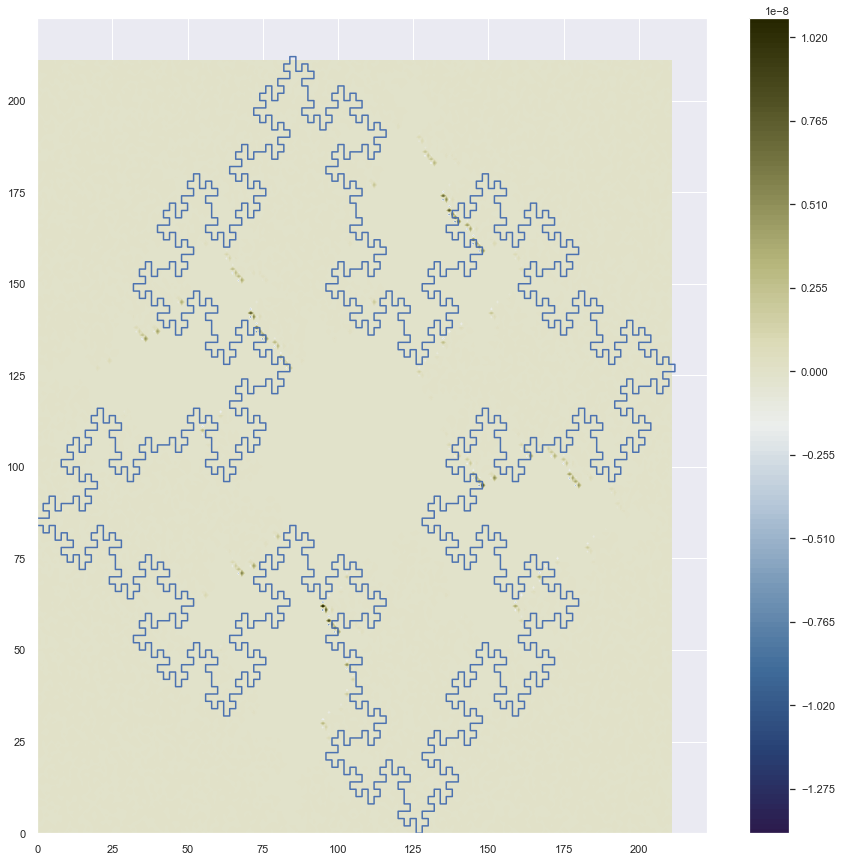

In [343]:
# plt.contourf(v[:,0].reshape(shape) / e[0])
plt.figure(figsize=(15, 15))
plt.contourf(tmp[1], cmap=cm, levels=max_idx)
plt.plot(*zip(*plot_list))
plt.colorbar()

In [ ]:
N = 200
diag = np.ones(N**2)
diag0 = -4*diag
diagx = diag[:-1]
diagy = diag[:-N]
M = scipy.spars/e.diags([diagy, diagx, diag0, diagx, diagy], [-N, -1, 0,1,N], format="csr")
e, v = scipy.sparse.linalg.eigs(M)
plt.contourf(v[:,0].reshape((N, N))/ e[0])
plt.colorbar()